<a href="https://colab.research.google.com/github/Raghad-Odwan/DermAI_Training/blob/main/DermAI_Cross_validaition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DermAI Model Training Cross-Validaition**

                    Palestine Technical University - Kadoorie
                      
                    Department of Computer Systems Engineering

                    DermAI: Intelligent Skin Cancer Detection Using Convolutional Neural Network & Transfer Learning Architectures                           




---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
%%javascript
function ClickConnect(){
    console.log("Preventing Colab timeout");
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000)

<IPython.core.display.Javascript object>



---



## **About this notebook**

This notebook has been prepared for the preparation and training of a machine learning model specialized in skin cancer detection.
The model performs binary classification of skin lesion images into two categories: Benign and Malignant.


### **Dataset Source**

The dataset used in this project was collected from the following sources:


*   **ISIC Archive**
*   **Kaggle**



The dataset contains approximately **13,294** benign and **6,211** malignant images, providing a total of around **19,505** samples used for training, validation, and testing.




---




### Notebook Structure

This notebook is organized into three main sections:

**-Data Loading, Verification, and Preprocessing**

This section focuses on importing the dataset, verifying its structure, cleaning inconsistencies, and performing Exploratory Data Analysis (EDA).
Steps include resizing, normalization, data augmentation, and splitting the dataset into training, validation, and testing subsets.

**-Model Training and Evaluation**

In this section, a machine learning model is implemented and trained for skin lesion classification.
The process includes model configuration, training, and performance evaluation using metrics such as accuracy, precision, recall, and F1-score.
Optimization methods are also applied to ensure stable and efficient training.

**-Result Interpretation and Visualization**

This part is dedicated to analyzing the model’s predictions and interpreting its decision-making process using Grad-CAM and other visualization tools.
It highlights how the model distinguishes between benign and malignant lesions, providing insights into reliability and interpretability.



---


**Note: This notebook represents a core component of the DermAI Graduation Project at Palestine Technical University – Kadoorie.
It aims to demonstrate the end-to-end process of building an intelligent, interpretable, and efficient system for skin cancer classification, contributing to early detection and supporting clinical decision-making.**


---



## **Part One: Dataset Preparation & Preprocessing**

In [ ]:
# Import required libraries
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define main dataset path
base_dir = "/content/drive/MyDrive/Dataset/Dataset"
folders = ["benign", "malignant"]

print("Base directory:", base_dir)
for folder in folders:
    path = os.path.join(base_dir, folder)
    print(f"{folder}: {len(os.listdir(path))} files")

Base directory: /content/drive/MyDrive/Dataset/Dataset
benign: 13291 files
malignant: 6210 files


In [ ]:
# Create a folder for problematic images
dup_dir = os.path.join(base_dir, "duplicates_or_corrupted")
os.makedirs(dup_dir, exist_ok=True)
print("Duplicate/Corrupted folder created at:", dup_dir)

Duplicate/Corrupted folder created at: /content/drive/MyDrive/Dataset/Dataset/duplicates_or_corrupted


In [ ]:
# Define an image cleaning class
class ImageCleaner:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.folders_to_check = ['benign', 'malignant']
        self.problem_folder = self.base_path / 'duplicates_or_corrupted'
        self.problem_folder.mkdir(exist_ok=True)
        self.stats = {'total_checked': 0, 'corrupted': 0, 'duplicates': 0, 'low_quality': 0, 'healthy': 0}
        self.image_hashes = defaultdict(list)

    def calculate_hash(self, image_path):
        import hashlib
        try:
            hasher = hashlib.md5()
            with open(image_path, 'rb') as f:
                buf = f.read()
                hasher.update(buf)
            return hasher.hexdigest()
        except:
            return None

    def is_image_corrupted(self, image_path):
        try:
            with Image.open(image_path) as img:
                img.verify()
            return False
        except:
            return True

    def check_image_quality(self, image_path, min_width=50, min_height=50):
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                if width < min_width or height < min_height:
                    return False
                if os.path.getsize(image_path) < 1000:
                    return False
            return True
        except:
            return False

    def move_to_problem_folder(self, image_path):
        try:
            dest_subfolder = self.problem_folder / image_path.parent.name
            dest_subfolder.mkdir(exist_ok=True)
            shutil.move(str(image_path), str(dest_subfolder / image_path.name))
        except Exception as e:
            print(f"Error moving {image_path.name}: {e}")

    def clean_folder(self, folder_name):
        folder_path = self.base_path / folder_name
        image_exts = ['.jpg', '.jpeg', '.png']
        images = [f for f in folder_path.iterdir() if f.suffix.lower() in image_exts]
        print(f"Cleaning {folder_name} ({len(images)} images)...")

        for img_path in tqdm(images, desc=f"Checking {folder_name}"):
            self.stats['total_checked'] += 1
            if self.is_image_corrupted(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['corrupted'] += 1
                continue
            if not self.check_image_quality(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['low_quality'] += 1
                continue
            img_hash = self.calculate_hash(img_path)
            if img_hash in self.image_hashes:
                self.move_to_problem_folder(img_path)
                self.stats['duplicates'] += 1
            else:
                self.image_hashes[img_hash].append(str(img_path))
                self.stats['healthy'] += 1

    def clean_all(self):
        for folder in self.folders_to_check:
            self.clean_folder(folder)
        print("\nCleaning Summary:")
        for k, v in self.stats.items():
            print(f"{k}: {v}")

# Run the cleaning process
cleaner = ImageCleaner(base_dir)
cleaner.clean_all()

Cleaning benign (13291 images)...


Checking benign: 100%|██████████| 13291/13291 [04:38<00:00, 47.76it/s] 


Cleaning malignant (6210 images)...


Checking malignant: 100%|██████████| 6210/6210 [02:16<00:00, 45.48it/s] 


Cleaning Summary:
total_checked: 19501
corrupted: 0
duplicates: 0
low_quality: 0
healthy: 19501


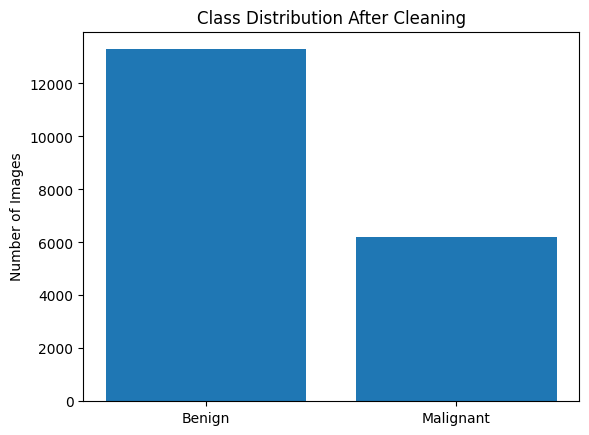

In [ ]:
# Visualize class distribution
count_benign = len(os.listdir(os.path.join(base_dir, "benign")))
count_malignant = len(os.listdir(os.path.join(base_dir, "malignant")))
plt.bar(["Benign", "Malignant"], [count_benign, count_malignant])
plt.title("Class Distribution After Cleaning")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
# Resize all images to (224x224)
IMG_SIZE = (224, 224)
for cat in folders:
    src_dir = os.path.join(base_dir, cat)
    files = os.listdir(src_dir)
    for fname in tqdm(files, desc=f"Resizing {cat}"):
        path = os.path.join(src_dir, fname)
        try:
            img = cv2.imread(path)
            if img is None: continue
            resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(path, resized)
        except:
            continue

Resizing malignant: 100%|██████████| 6210/6210 [02:03<00:00, 50.19it/s]


In [ ]:
# Split dataset (70% train, 15% val, 15% test)
split_dir = "/content/ai/Dataset_split"
os.makedirs(split_dir, exist_ok=True)

rows = []
for label in folders:
    path = os.path.join(base_dir, label)
    for fname in os.listdir(path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            rows.append({'path': os.path.join(path, fname), 'label': label})

df = pd.DataFrame(rows)
train_temp, test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train, val = train_test_split(train_temp, test_size=0.1765, stratify=train_temp['label'], random_state=42)

for subset in ['train', 'val', 'test']:
    for label in folders:
        os.makedirs(os.path.join(split_dir, subset, label), exist_ok=True)

def copy_images(df_subset, subset_name):
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc=f"Copying {subset_name}"):
        dest = os.path.join(split_dir, subset_name, row['label'], os.path.basename(row['path']))
        shutil.copy2(row['path'], dest)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

print(f"\nDataset split completed successfully!")
print(f"Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")

Copying test: 100%|██████████| 2926/2926 [00:10<00:00, 266.10it/s]


Dataset split completed successfully!
Train: 13649 | Val: 2926 | Test: 2926




---

####  Build DataFrame & Quick Integrity Check

In [ ]:
# Count the number of image files in each class folder (benign and malignant)
# This function walks through all subdirectories and counts only valid image files.
import os, sys, traceback
base_path = "/content/drive/MyDrive/Dataset/Dataset"

def count_images_in_folder(folder):
    exts = ('.jpg','.jpeg','.png','.bmp')
    cnt = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(exts):
                cnt += 1
    return cnt

for cls in ['benign','malignant']:
    p = os.path.join(base_path, cls)
    if not os.path.exists(p):
        print(f" WARNING: folder not found: {p}")
    else:
        print(f"{cls}: {count_images_in_folder(p):,} images")

benign: 13,291 images
malignant: 6,210 images


In [ ]:
import os
import pandas as pd
from PIL import Image
import random
# build dataframe (paths + labels)
rows=[]
exts = ('.jpg','.jpeg','.png','.bmp')
for cls in ['benign','malignant']:
    folder = os.path.join(base_path, cls)
    if not os.path.exists(folder):
        continue
    for root, dirs, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(exts):
                rows.append({'path': os.path.join(root, fname), 'label': cls})

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['label_idx'] = df['label'].map({'benign':0, 'malignant':1})
print("Total samples:", len(df))
print(df['label'].value_counts())

Total samples: 19501
label
benign       13291
malignant     6210
Name: count, dtype: int64


In [ ]:
#  quick corrupted-files check (lightweight, may take time if dataset big)
#  try to open the first N images from each class to detect obvious corruption
from PIL import Image
import random

def check_samples(df, n_per_class=20):
    corrupted = []
    for cls in df['label'].unique():
        paths = df[df['label']==cls]['path'].tolist()
        sample_paths = random.sample(paths, min(n_per_class, len(paths)))
        for p in sample_paths:
            try:
                img = Image.open(p)
                img.verify()
            except Exception as e:
                corrupted.append((p, str(e)))
    return corrupted

corrupted_examples = check_samples(df, n_per_class=30)
if corrupted_examples:
    print(" Found corrupted or unreadable sample(s):", len(corrupted_examples))
    for p,err in corrupted_examples[:5]:
        print("-", p, "=>", err)
else:
    print(" Quick corrupted-sample check passed successfully (no issues in sampled files).")

 Quick corrupted-sample check passed successfully (no issues in sampled files).


In [ ]:
# Save metadata CSV
out_csv = "/content/drive/MyDrive/ai/data/df_metadata.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False)
print(" Metadata saved to:", out_csv)

 Metadata saved to: /content/drive/MyDrive/ai/data/df_metadata.csv


In [ ]:
display(df.head(10))
print("\nCounts (sanity):")
print(df['label'].value_counts())

,path,label,label_idx
0,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
1,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
2,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
3,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
4,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
5,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
6,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
7,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
8,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
9,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0



Counts (sanity):
label
benign       13291
malignant     6210
Name: count, dtype: int64


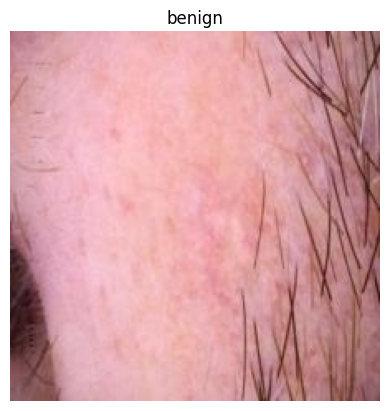

In [ ]:
# Quick test reading data
# Randomly load and display one sample image from the dataset
# to verify that image paths are correct and preprocessing worked properly.
from tensorflow.keras.preprocessing import image
import numpy as np
import random
import matplotlib.pyplot as plt

sample = random.choice(df['path'].tolist())
img = image.load_img(sample, target_size=(224,224))
plt.imshow(img)
plt.axis('off')
plt.title(sample.split('/')[-2])
plt.show()



---



## **Part Two: Model Training and Evaluation**

### **Part 2.1: Cross_Valditon**

In [ ]:
# Import libraries
import os, math, gc
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger

# Parameters
# Defines image size, batch size, epochs, and model saving directory
DRIVE_BASE = "/content/drive/MyDrive"
DF_PATH = os.path.join(DRIVE_BASE, "ai/data/df_metadata.csv")
MODELS_DIR = os.path.join(DRIVE_BASE, "DermAI_models_resnet")
os.makedirs(MODELS_DIR, exist_ok=True)

IMG_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 30
N_FOLDS = 3
RANDOM_STATE = 42
VERBOSE = 1

In [ ]:
# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [ ]:
# Read & Inspect Metadata
meta_csv = "/content/drive/MyDrive/ai/data/df_metadata.csv"
df = pd.read_csv(meta_csv)

print("Loaded df:", meta_csv)
print("Total samples:", len(df))
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nFirst 10 rows:")
display(df.head(10))

# Prepare X and y for training
X = df['path'].values
y = df['label_idx'].values

Loaded df: /content/drive/MyDrive/ai/data/df_metadata.csv
Total samples: 19501

Label distribution:
label
benign       13291
malignant     6210
Name: count, dtype: int64

First 10 rows:


,path,label,label_idx
0,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
1,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
2,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
3,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
4,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
5,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
6,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
7,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
8,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
9,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0


**Data Generators**

* Prepare image generators for training and validation.
* Training generator applies data augmentation to improve model generalization, while validation generator only rescales pixel values.
* ralies moderate augmentation; validation only rescales.ining generator app

In [ ]:
# Data Generators (augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1]
)

val_datagen = ImageDataGenerator(rescale=1./255)



---





---



**Model Building**

In [ ]:
# Build ResNet50 binary classifier with fine-tuning of the last N layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW

def build_resnet_binary(input_shape=(224,224,3), unfreeze_last_n=40):
    # Load base ResNet50 without top layers
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers initially
    for layer in base.layers:
        layer.trainable = False

    # Unfreeze last N layers (except BatchNorm layers for training stability)
    for layer in base.layers[-unfreeze_last_n:]:
        if 'batch_normalization' in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True

    # Classification head
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base.input, outputs=outputs)

    # AdamW optimizer (recommended for fine-tuning)
    model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-4
    ),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
    return model



---





---



In [ ]:
# Utility Functions for Dataset Loading & Preprocessing
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def compute_weights(y_array):
    classes = np.unique(y_array)
    cw = compute_class_weight('balanced', classes=classes, y=y_array)
    return {int(c): float(w) for c,w in zip(classes, cw)}

def print_generator_info(gen, name="generator"):
    print(f"{name} class_indices:", getattr(gen, 'class_indices', None))
    if hasattr(gen, 'classes'):
        u,c = np.unique(gen.classes, return_counts=True)
        print(f"{name} counts:", dict(zip(u,c)))



---



plot (Accuracy/Loss, Confusion Matrix, ROC Curve) for each flods and save it

In [ ]:
plots_dir = "/content/drive/MyDrive/DermAI_Training_resluts_plots"
os.makedirs(plots_dir, exist_ok=True)

In [ ]:
def plot_training_curves(history, fold_no, save_dir=plots_dir):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy Curve – Fold {fold_no}')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss Curve – Fold {fold_no}')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    # save
    save_path = os.path.join(save_dir, f"fold_{fold_no}_accuracy_loss.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# confusion_matrix
def plot_confusion_matrix(true, preds, fold_no, save_dir=plots_dir):
    cm = confusion_matrix(true, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix – Fold {fold_no}')
    plt.xlabel('Predicted'); plt.ylabel('Actual')

    save_path = os.path.join(save_dir, f"fold_{fold_no}_confusion_matrix.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# ROC Curve
def plot_roc(true, prob, fold_no, save_dir=plots_dir):
    fpr, tpr, _ = roc_curve(true, prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(f'ROC Curve – Fold {fold_no}')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend()

    save_path = os.path.join(save_dir, f"fold_{fold_no}_roc_curve.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



---





---



For each fold:
*  Split data into training and validation subsets while preserving class balance.
*   Build and train a ResNet50 model on the training subset.
* Evaluate model performance on the validation subset (Accuracy, Precision, Recall, F1).
* Save best model weights and record per-fold metrics.
And after that Results from all folds are stored in 'fold_metrics' for later summary and analysis.

In [ ]:
import math, gc, os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

df = pd.read_csv('/content/drive/MyDrive/ai/data/df_metadata.csv')
df_cv = df.copy()

X = df_cv['path'].values
y = df_cv['label_idx'].values

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
splits = list(skf.split(X, y))

##### Fold 1

class_weight: {0: 0.7336343115124153, 1: 1.570048309178744}
Found 13000 validated image filenames.
Found 6501 validated image filenames.
train_gen class_indices: None
val_gen class_indices: None
Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.7190 - auc: 0.7959 - loss: 0.5444
Epoch 1: val_loss improved from inf to 1.39750, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold1.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 305s 696ms/step - accuracy: 0.7190 - auc: 0.7960 - loss: 0.5443 - val_accuracy: 0.7316 - val_auc: 0.7486 - val_loss: 1.3975 - learning_rate: 1.0000e-04
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7684 - auc: 0.8604 - loss: 0.4601
Epoch 2: val_loss did not improve from 1.39750
407/407 ━━━━━━━━━━━━━━━━━━━━ 257s 630ms/step - accuracy: 0.7684 - auc: 0.8604 - loss: 0.4600 - val_accuracy: 0.7457 - val_auc: 0.7377 - val_loss: 1.7314 - learning_rate: 1.0000e-04
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accu

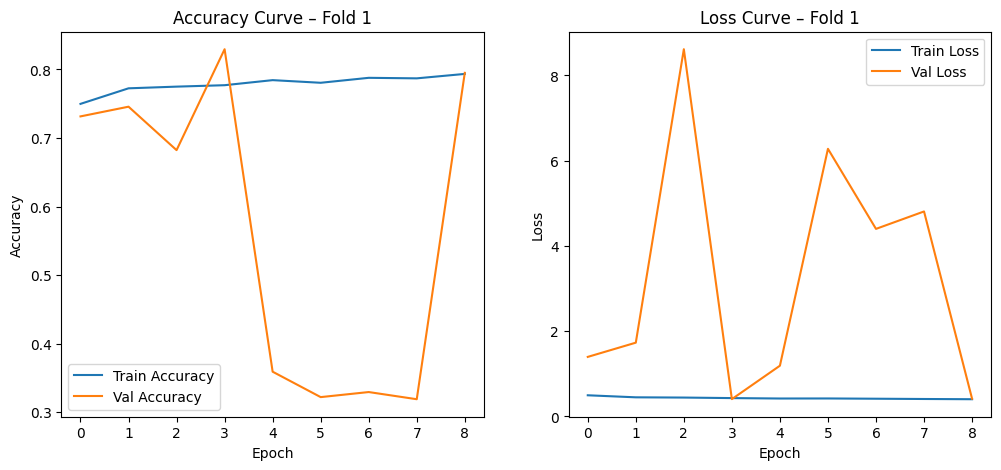

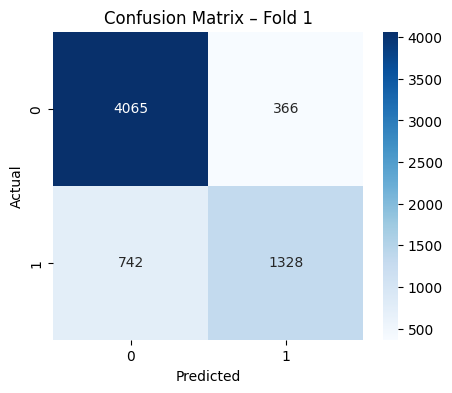

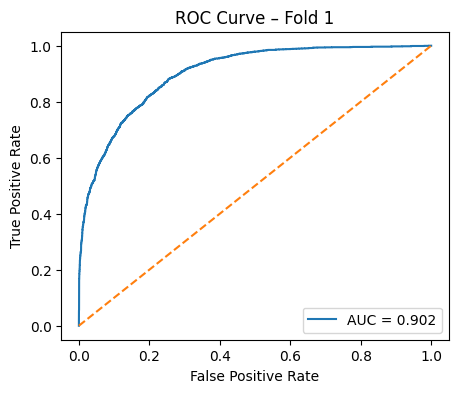

In [ ]:
# Fold 1
fold_no = 1

# Data split
train_idx, val_idx = splits[0]
train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
val_df   = pd.DataFrame({'path': X[val_idx],   'label_idx': y[val_idx]})

class_weight = compute_weights(train_df['label_idx'].values)
print("class_weight:", class_weight)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=False
)

print_generator_info(train_gen, "train_gen")
print_generator_info(val_gen, "val_gen")


# Build Model
model = build_resnet_binary(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    unfreeze_last_n=40
)


# Callbacks
ckpt_path = os.path.join(MODELS_DIR, f"best_resnet_fold{fold_no}.keras")
csv_log_path = os.path.join(MODELS_DIR, f"training_log_fold{fold_no}.csv")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    CSVLogger(csv_log_path)
]

steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
val_steps = math.ceil(len(val_df) / BATCH_SIZE)

# Training
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=VERBOSE
)


# Load Best Model
best = tf.keras.models.load_model(ckpt_path)

val_gen_eval = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=False
)

preds_prob = best.predict(val_gen_eval, steps=val_steps, verbose=VERBOSE)
preds = (preds_prob.ravel() > 0.5).astype(int)
true = val_df['label_idx'].values[:len(preds)]

acc  = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec  = recall_score(true, preds, zero_division=0)
f1   = f1_score(true, preds, zero_division=0)

print(f"Fold {fold_no} -> acc:{acc:.4f}, prec:{prec:.4f}, rec:{rec:.4f}, f1:{f1:.4f}")
print(classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))
print("Confusion matrix:\n", confusion_matrix(true, preds))

#  Visualization for this Fold
plot_training_curves(history, fold_no)
plot_confusion_matrix(true, preds, fold_no)
plot_roc(true, preds_prob.ravel(), fold_no)

##### Fold 2

class_weight: {0: 0.7336079449272092, 1: 1.5701690821256038}
Found 13001 validated image filenames.
Found 6500 validated image filenames.
train_gen class_indices: None
val_gen class_indices: None
Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.7262 - auc: 0.8001 - loss: 0.5347
Epoch 1: val_loss improved from inf to 1.23393, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold2.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 315s 715ms/step - accuracy: 0.7262 - auc: 0.8002 - loss: 0.5346 - val_accuracy: 0.3360 - val_auc: 0.8812 - val_loss: 1.2339 - learning_rate: 1.0000e-04
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7746 - auc: 0.8697 - loss: 0.4476
Epoch 2: val_loss did not improve from 1.23393
407/407 ━━━━━━━━━━━━━━━━━━━━ 271s 617ms/step - accuracy: 0.7746 - auc: 0.8697 - loss: 0.4476 - val_accuracy: 0.6822 - val_auc: 0.5581 - val_loss: 4.1576 - learning_rate: 1.0000e-04
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - acc

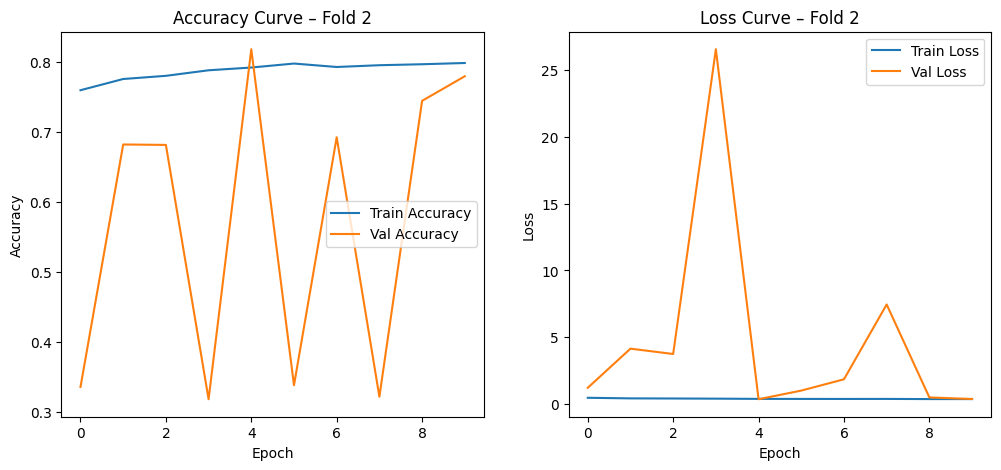

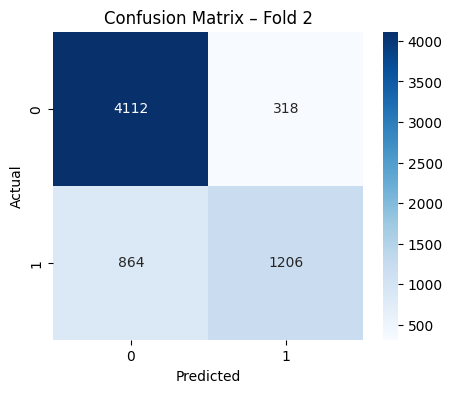

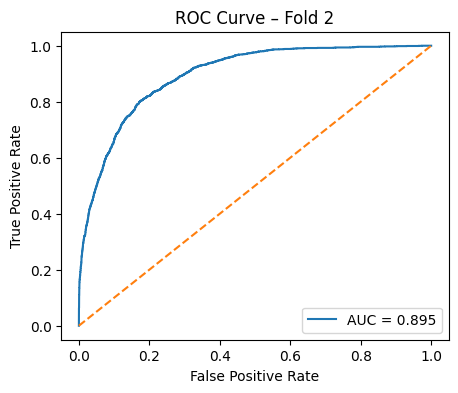

In [ ]:
# Fold 2
fold_no = 2

# Data split
train_idx, val_idx = splits[1]
train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
val_df   = pd.DataFrame({'path': X[val_idx],   'label_idx': y[val_idx]})

class_weight = compute_weights(train_df['label_idx'].values)
print("class_weight:", class_weight)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=False
)

print_generator_info(train_gen, "train_gen")
print_generator_info(val_gen, "val_gen")


# Build Model
model = build_resnet_binary(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    unfreeze_last_n=40
)


# Callbacks
ckpt_path = os.path.join(MODELS_DIR, f"best_resnet_fold{fold_no}.keras")
csv_log_path = os.path.join(MODELS_DIR, f"training_log_fold{fold_no}.csv")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    CSVLogger(csv_log_path)
]

steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
val_steps = math.ceil(len(val_df) / BATCH_SIZE)

# Training
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=VERBOSE
)


# Load Best Model
best = tf.keras.models.load_model(ckpt_path)

val_gen_eval = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=False
)

preds_prob = best.predict(val_gen_eval, steps=val_steps, verbose=VERBOSE)
preds = (preds_prob.ravel() > 0.5).astype(int)
true = val_df['label_idx'].values[:len(preds)]

acc  = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec  = recall_score(true, preds, zero_division=0)
f1   = f1_score(true, preds, zero_division=0)

print(f"Fold {fold_no} -> acc:{acc:.4f}, prec:{prec:.4f}, rec:{rec:.4f}, f1:{f1:.4f}")
print(classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))
print("Confusion matrix:\n", confusion_matrix(true, preds))

# Visualization for this Fold
plot_training_curves(history, fold_no)
plot_confusion_matrix(true, preds, fold_no)
plot_roc(true, preds_prob.ravel(), fold_no)

##### Fold 3

class_weight: {0: 0.7336079449272092, 1: 1.5701690821256038}
Found 13001 validated image filenames.
Found 6500 validated image filenames.
train_gen class_indices: None
val_gen class_indices: None
Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.7127 - auc: 0.7858 - loss: 0.5487
Epoch 1: val_loss improved from inf to 2.86160, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold3.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 306s 697ms/step - accuracy: 0.7127 - auc: 0.7859 - loss: 0.5486 - val_accuracy: 0.3249 - val_auc: 0.8442 - val_loss: 2.8616 - learning_rate: 1.0000e-04
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7729 - auc: 0.8703 - loss: 0.4463
Epoch 2: val_loss did not improve from 2.86160
407/407 ━━━━━━━━━━━━━━━━━━━━ 284s 627ms/step - accuracy: 0.7729 - auc: 0.8703 - loss: 0.4464 - val_accuracy: 0.6834 - val_auc: 0.5063 - val_loss: 16.6261 - learning_rate: 1.0000e-04
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - ac

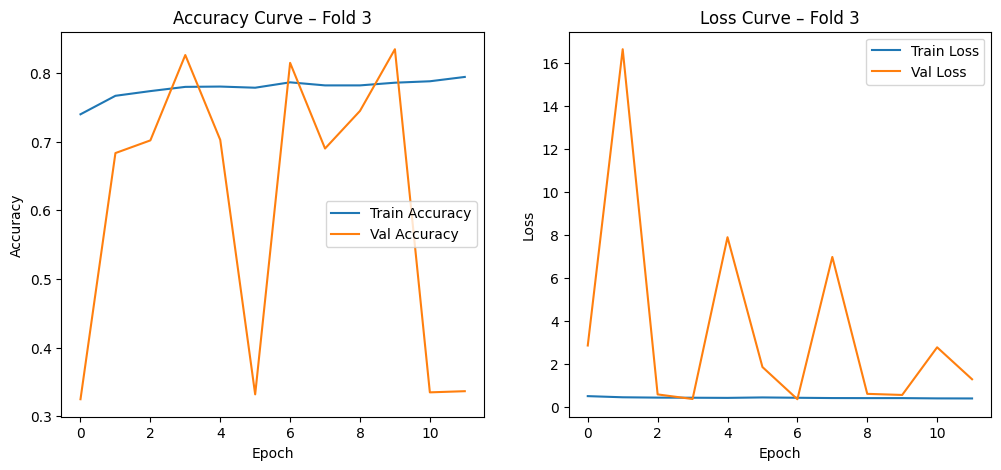

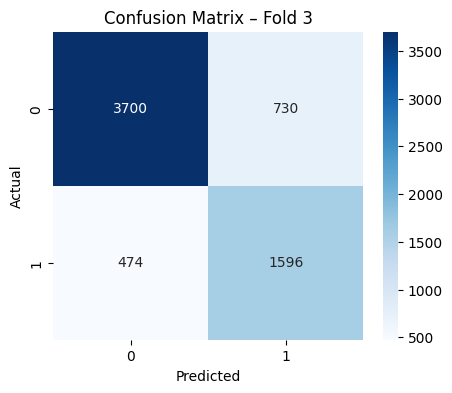

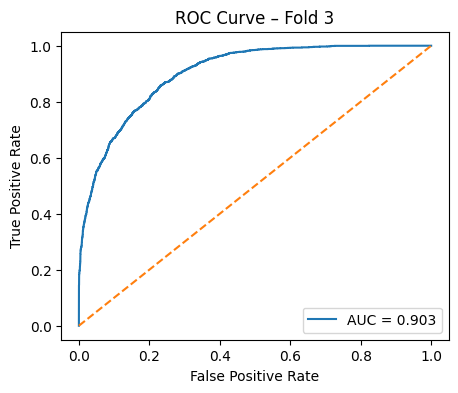

In [ ]:
# Fold 3
fold_no = 3

# Data split
train_idx, val_idx = splits[2]
train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
val_df   = pd.DataFrame({'path': X[val_idx],   'label_idx': y[val_idx]})

class_weight = compute_weights(train_df['label_idx'].values)
print("class_weight:", class_weight)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=False
)

print_generator_info(train_gen, "train_gen")
print_generator_info(val_gen, "val_gen")


# Build Model
model = build_resnet_binary(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    unfreeze_last_n=40
)


# Callbacks
ckpt_path = os.path.join(MODELS_DIR, f"best_resnet_fold{fold_no}.keras")
csv_log_path = os.path.join(MODELS_DIR, f"training_log_fold{fold_no}.csv")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    CSVLogger(csv_log_path)
]

steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
val_steps = math.ceil(len(val_df) / BATCH_SIZE)

# Training
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=VERBOSE
)


# Load Best Model
best = tf.keras.models.load_model(ckpt_path)

val_gen_eval = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label_idx',
    target_size=IMG_SIZE, class_mode='raw',
    batch_size=BATCH_SIZE, shuffle=False
)

preds_prob = best.predict(val_gen_eval, steps=val_steps, verbose=VERBOSE)
preds = (preds_prob.ravel() > 0.5).astype(int)
true = val_df['label_idx'].values[:len(preds)]

acc  = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec  = recall_score(true, preds, zero_division=0)
f1   = f1_score(true, preds, zero_division=0)

print(f"Fold {fold_no} -> acc:{acc:.4f}, prec:{prec:.4f}, rec:{rec:.4f}, f1:{f1:.4f}")
print(classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))
print("Confusion matrix:\n", confusion_matrix(true, preds))

# Visualization for this Fold
plot_training_curves(history, fold_no)
plot_confusion_matrix(true, preds, fold_no)
plot_roc(true, preds_prob.ravel(), fold_no)



---



---





---



### **Part 2.2: Ensemble Model Construction and Evaluation**

In [ ]:
# Libraries & Path
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, classification_report
)
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Input, Model
import tensorflow as tf
PLOTS_DIR = "/content/drive/MyDrive/DermAI_plots"
MODELS_DIR = "/content/drive/MyDrive/DermAI_models_resnet"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [ ]:
# Load Fold Models
fold_model_files = [
    os.path.join(MODELS_DIR, "best_resnet_fold1.keras"),
    os.path.join(MODELS_DIR, "best_resnet_fold2.keras"),
    os.path.join(MODELS_DIR, "best_resnet_fold3.keras")
]

loaded_models = []
for p in fold_model_files:
    m = tf.keras.models.load_model(p)
    m.trainable = False
    loaded_models.append(m)

In [ ]:
# Build Ensemble Model
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
ensemble_input = Input(shape=input_shape)

outputs = [m(ensemble_input, training=False) for m in loaded_models]

def average_preds(tensors):
    stack = tf.stack(tensors, axis=0)
    return tf.reduce_mean(stack, axis=0)

avg = Lambda(average_preds)(outputs)

ensemble_model = Model(inputs=ensemble_input, outputs=avg)

ensemble_save_path = os.path.join(MODELS_DIR, "ensemble_resnet_avg.keras")
ensemble_model.save(ensemble_save_path)
ensemble_model

<Functional name=functional_5, built=True>

In [ ]:
# Plot functions
def save_confusion_matrix(true, preds, fold_no):
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Ensemble Confusion Matrix – Fold {fold_no}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    path = os.path.join(PLOTS_DIR, f"ensemble_fold{fold_no}_cm.png")
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.close()
    return path

def save_roc_curve(true, prob, fold_no):
    fpr, tpr, _ = roc_curve(true, prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(f'Ensemble ROC Curve – Fold {fold_no}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    path = os.path.join(PLOTS_DIR, f"ensemble_fold{fold_no}_roc.png")
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.close()
    return path

In [ ]:
# Evaluate Ensemble Across Folds
ensemble_metrics = []
threshold_results = []

for fold_no, split in enumerate([splits[0], splits[1], splits[2]], start=1):
    train_idx, val_idx = split
    val_df = pd.DataFrame({'path': X[val_idx], 'label_idx': y[val_idx]})

    val_gen_eval = val_datagen.flow_from_dataframe(
        val_df, x_col='path', y_col='label_idx',
        target_size=IMG_SIZE, class_mode='raw',
        batch_size=16, shuffle=False,
        seed=42
    )

    val_steps = int(np.ceil(len(val_df) / BATCH_SIZE))
    preds_prob = ensemble_model.predict(val_gen_eval, steps=val_steps, verbose=0)
    preds_prob = preds_prob.ravel()
    true = val_df['label_idx'].values[:len(preds_prob)]

    print(f"\nFold {fold_no}")

    # Evaluate threshold = 0.5
    preds = (preds_prob > 0.5).astype(int)
    acc  = accuracy_score(true, preds)
    prec = precision_score(true, preds, zero_division=0)
    rec  = recall_score(true, preds, zero_division=0)
    f1   = f1_score(true, preds, zero_division=0)

    ensemble_metrics.append({
        'fold': fold_no,
        'threshold': 0.5,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

    print("Threshold = 0.50")
    print(f"Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")
    print(classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))

    # Additional thresholds
    for thresh in [0.35, 0.40, 0.45]:
        preds_t = (preds_prob > thresh).astype(int)
        acc_t  = accuracy_score(true, preds_t)
        prec_t = precision_score(true, preds_t, zero_division=0)
        rec_t  = recall_score(true, preds_t, zero_division=0)
        f1_t   = f1_score(true, preds_t, zero_division=0)

        threshold_results.append({
            'fold': fold_no,
            'threshold': thresh,
            'accuracy': acc_t,
            'precision': prec_t,
            'recall': rec_t,
            'f1': f1_t
        })

        print(f"\nThreshold = {thresh:.2f}")
        print(f"Acc={acc_t:.3f}, Prec={prec_t:.3f}, Rec={rec_t:.3f}, F1={f1_t:.3f}")

Found 6501 validated image filenames.

Fold 1
Threshold = 0.50
Acc=0.834, Prec=0.764, Rec=0.694, F1=0.728
              precision    recall  f1-score   support

      benign       0.86      0.90      0.88      2220
   malignant       0.76      0.69      0.73      1044

    accuracy                           0.83      3264
   macro avg       0.81      0.80      0.80      3264
weighted avg       0.83      0.83      0.83      3264


Threshold = 0.35
Acc=0.808, Prec=0.653, Rec=0.852, F1=0.740

Threshold = 0.40
Acc=0.819, Prec=0.686, Rec=0.802, F1=0.739

Threshold = 0.45
Acc=0.827, Prec=0.723, Rec=0.744, F1=0.733
Found 6500 validated image filenames.

Fold 2
Threshold = 0.50
Acc=0.827, Prec=0.748, Rec=0.674, F1=0.709
              precision    recall  f1-score   support

      benign       0.86      0.90      0.88      2240
   malignant       0.75      0.67      0.71      1024

    accuracy                           0.83      3264
   macro avg       0.80      0.79      0.79      3264
weight

In [ ]:
# Save results
ensemble_df = pd.DataFrame(ensemble_metrics)
threshold_df = pd.DataFrame(threshold_results)

ensemble_df.to_csv(os.path.join(PLOTS_DIR, "ensemble_results.csv"), index=False)
threshold_df.to_csv(os.path.join(PLOTS_DIR, "threshold_results.csv"), index=False)

In [ ]:
# Calculate averages
print("\nAverage results:")
for thresh in [0.35, 0.40, 0.45, 0.50]:
    if thresh == 0.50:
        subset = ensemble_df
    else:
        subset = threshold_df[threshold_df['threshold'] == thresh]

    print(f"\nThreshold {thresh:.2f}:")
    print(f"  Acc={subset['accuracy'].mean():.3f}, Prec={subset['precision'].mean():.3f}, Rec={subset['recall'].mean():.3f}, F1={subset['f1'].mean():.3f}")




Average results:

Threshold 0.35:
  Acc=0.808, Prec=0.652, Rec=0.840, F1=0.734

Threshold 0.40:
  Acc=0.818, Prec=0.682, Rec=0.793, F1=0.733

Threshold 0.45:
  Acc=0.825, Prec=0.718, Rec=0.737, F1=0.727

Threshold 0.50:
  Acc=0.829, Prec=0.754, Rec=0.681, F1=0.716


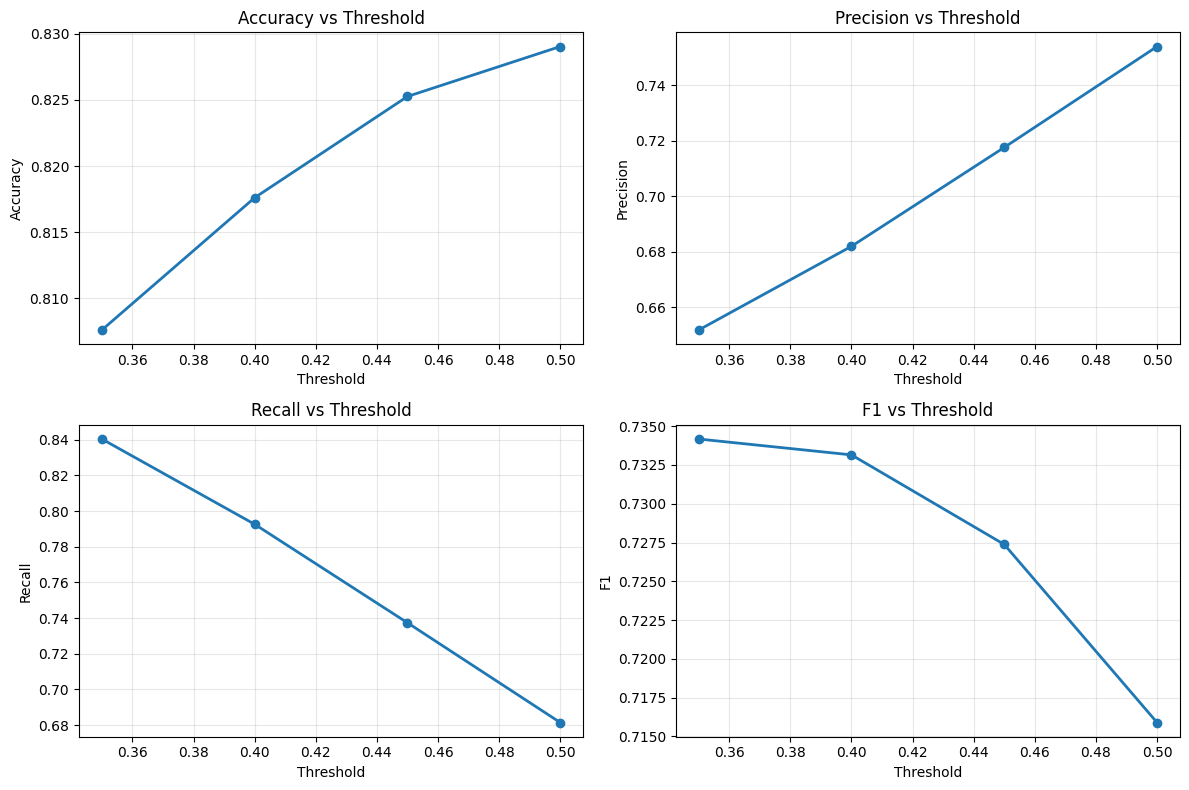

In [ ]:
# Plot 1: Thresholds comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    ax = axes[i//2, i%2]

    # Average line
    avgs = []
    for thresh in [0.35, 0.40, 0.45, 0.50]:
        if thresh == 0.50:
            avgs.append(ensemble_df[metric].mean())
        else:
            avgs.append(threshold_df[threshold_df['threshold'] == thresh][metric].mean())

    ax.plot([0.35, 0.40, 0.45, 0.50], avgs, marker='o', linewidth=2)
    ax.set_xlabel('Threshold')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} vs Threshold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'threshold_comparison.png'), dpi=200)
plt.show()


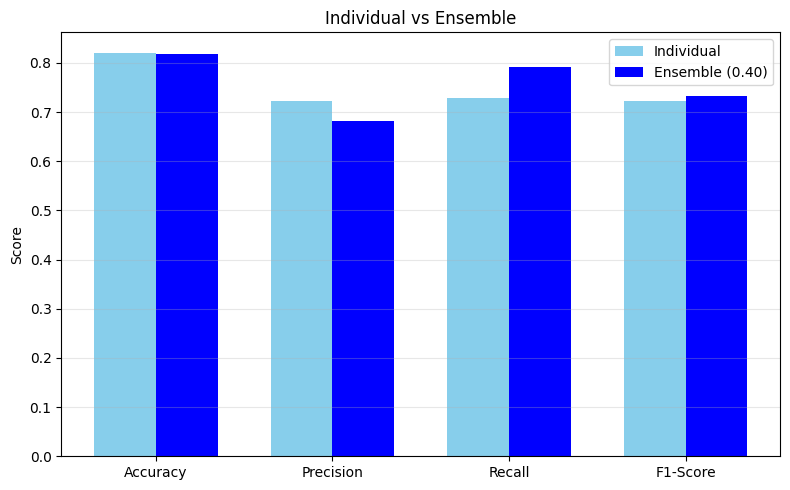

In [ ]:
# Plot 2: Individual vs Ensemble
fig, ax = plt.subplots(figsize=(8, 5))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
individual = [0.8213, 0.7233, 0.7282, 0.7223]

# Use threshold 0.40 results
ensemble_040 = threshold_df[threshold_df['threshold'] == 0.40]
ensemble_vals = [
    ensemble_040['accuracy'].mean(),
    ensemble_040['precision'].mean(),
    ensemble_040['recall'].mean(),
    ensemble_040['f1'].mean()
]

x = range(len(metrics))
width = 0.35

ax.bar([i - width/2 for i in x], individual, width, label='Individual', color='skyblue')
ax.bar([i + width/2 for i in x], ensemble_vals, width, label='Ensemble (0.40)', color='blue')

ax.set_ylabel('Score')
ax.set_title('Individual vs Ensemble')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'individual_vs_ensemble.png'), dpi=200)
plt.show()

In [ ]:
print(f"\nPlots saved to {PLOTS_DIR}")


Plots saved to /content/drive/MyDrive/DermAI_plots




---





---



## **Part Three: Results Analysis and Discussion**

#### **Results Summary**

The DermAI training pipeline demonstrated stable and reliable performance across the three cross-validation folds.
Model accuracy consistently ranged between **81–83%**, while F1-scores remained within **0.67–0.73**, reflecting low variance and strong generalization despite changes in the validation split.
Both precision and recall showed similarly constrained fluctuation across folds, indicating that the model maintained balanced behavior even under the dataset’s inherent imbalance
(≈ **13,291 benign** vs. **6,211 malignant** samples).

The ensemble model, built by averaging output probabilities from the three fine-tuned ResNet50 classifiers, further enhanced prediction stability.
Although overall accuracy did not dramatically increase, the ensemble approach produced smoother probability distributions, reduced fold-to-fold variability, and improved malignant-class sensitivity—highlighting the robustness gained through model aggregation.



---



#### **Discussion & Analysis Resuls**



The cross-validation outcomes reveal that the DermAI classifier preserves consistent performance across all folds, with no signs of overfitting to any single split.
Despite the malignant class being underrepresented, malignant recall remained in a reasonable and stable range **(0.58–0.77)**.
This indicates that the model successfully avoided collapsing toward the majority class and preserved meaningful discriminative ability for malignant lesions.

A major contributing factor to this stability is the use of class-weighted training, which compensated for the dataset imbalance by increasing the loss contribution of malignant samples.
Without class weighting, the model would likely over-predict the benign class—lowering malignant recall significantly and weakening clinical usefulness.
Fine-tuning the last portion of the ResNet50 backbone also enabled the network to learn high-level, lesion-specific visual patterns that distinguish malignant from benign cases.

The ensemble model added an additional layer of robustness by integrating multiple fold-specific perspectives of the dataset.
Ensembling reduced prediction noise, mitigated fold-specific weaknesses, and improved the consistency of malignant detection—especially at optimized decision thresholds such as **0.40**.



---



#### **Conclusion**

DermAI achieved stable, cross-validated performance with consistent accuracy, precision, recall, and F1-scores across the three folds.
The combination of class-weighted fine-tuning, deep ResNet50 feature extraction, and ensemble averaging proved effective in maintaining balanced learning under significant data imbalance.

Although detecting malignant lesions remains the most challenging aspect—owing to their visual variability and minority representation—the model demonstrates strong generalization characteristics and provides a solid foundation for:
* final full-dataset training
* integration into larger diagnostic pipelines
* further refinement in future work.

Overall, the results validate the reliability and practical potential of the DermAI system for assisting in early skin-cancer detection.



---



#